![](https://i.imgur.com/xeJ4ddr.jpg)
# Google - American Sign Language Fingerspelling Recognition
<hr>
Competition Link: <a>https://www.kaggle.com/competitions/asl-fingerspelling/data</a>
<hr>
<b>Generating text from American Sign Language (ASL) using keypoint data and an encoder-decoder architecture is a promising leap in accessibility technology. ASL is a vital means of communication for the Deaf community, but its understanding is not universal. This innovative approach leverages computer vision to capture ASL gestures as keypoint data and translates it into written text.The encoder processes the keypoints, extracting meaningful information, while the decoder converts this data into a coherent text representation. This technology holds immense potential for bridging communication gaps between Deaf and hearing individuals, making information and conversations more inclusive. It's a significant step toward a more inclusive and connected world, demonstrating the power of AI to break down barriers.</b>
<hr>

# Sample Hand Landmarks Example
![](https://i.imgur.com/l9djKwY.png)

# Encoder-Decoder Architecture With Bidirectional-LSTM

## Import Dependencies

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
pd.set_option('display.max_columns',300)
import json
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Embedding, Dense, Input, Lambda, Conv1D, MaxPool1D
from tensorflow.keras.models import Model
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Read Train Data

In [2]:
df = pd.read_csv("/kaggle/input/asl-fingerspelling/train.csv")
df

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road
...,...,...,...,...,...
67203,train_landmarks/2118949241.parquet,2118949241,388192924,88,431-366-2913
67204,train_landmarks/2118949241.parquet,2118949241,388225542,154,994-392-3850
67205,train_landmarks/2118949241.parquet,2118949241,388232076,95,https://www.tianjiagenomes.com
67206,train_landmarks/2118949241.parquet,2118949241,388235284,36,90 kerwood circle


## Filter Out Hand Landmarks

In [3]:
# ! pip install fastparquet pyarrow

In [4]:
landm = pd.read_parquet("/kaggle/input/asl-fingerspelling/train_landmarks/1019715464.parquet")
landm

,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,x_face_9,x_face_10,x_face_11,x_face_12,x_face_13,x_face_14,x_face_15,x_face_16,x_face_17,x_face_18,x_face_19,x_face_20,x_face_21,x_face_22,x_face_23,x_face_24,x_face_25,x_face_26,x_face_27,x_face_28,x_face_29,x_face_30,x_face_31,x_face_32,x_face_33,x_face_34,x_face_35,x_face_36,x_face_37,x_face_38,x_face_39,x_face_40,x_face_41,x_face_42,x_face_43,x_face_44,x_face_45,x_face_46,x_face_47,x_face_48,x_face_49,x_face_50,x_face_51,x_face_52,x_face_53,x_face_54,x_face_55,x_face_56,x_face_57,x_face_58,x_face_59,x_face_60,x_face_61,x_face_62,x_face_63,x_face_64,x_face_65,x_face_66,x_face_67,x_face_68,x_face_69,x_face_70,x_face_71,x_face_72,x_face_73,x_face_74,x_face_75,x_face_76,x_face_77,x_face_78,x_face_79,x_face_80,x_face_81,x_face_82,x_face_83,x_face_84,x_face_85,x_face_86,x_face_87,x_face_88,x_face_89,x_face_90,x_face_91,x_face_92,x_face_93,x_face_94,x_face_95,x_face_96,x_face_97,x_face_98,x_face_99,x_face_100,x_face_101,x_face_102,x_face_103,x_face_104,x_face_105,x_face_106,x_face_107,x_face_108,x_face_109,x_face_110,x_face_111,x_face_112,x_face_113,x_face_114,x_face_115,x_face_116,x_face_117,x_face_118,x_face_119,x_face_120,x_face_121,x_face_122,x_face_123,x_face_124,x_face_125,x_face_126,x_face_127,x_face_128,x_face_129,x_face_130,x_face_131,x_face_132,x_face_133,x_face_134,x_face_135,x_face_136,x_face_137,x_face_138,x_face_139,x_face_140,x_face_141,x_face_142,x_face_143,x_face_144,x_face_145,x_face_146,x_face_147,x_face_148,...,z_face_393,z_face_394,z_face_395,z_face_396,z_face_397,z_face_398,z_face_399,z_face_400,z_face_401,z_face_402,z_face_403,z_face_404,z_face_405,z_face_406,z_face_407,z_face_408,z_face_409,z_face_410,z_face_411,z_face_412,z_face_413,z_face_414,z_face_415,z_face_416,z_face_417,z_face_418,z_face_419,z_face_420,z_face_421,z_face_422,z_face_423,z_face_424,z_face_425,z_face_426,z_face_427,z_face_428,z_face_429,z_face_430,z_face_431,z_face_432,z_face_433,z_face_434,z_face_435,z_face_436,z_face_437,z_face_438,z_face_439,z_face_440,z_face_441,z_face_442,z_face_443,z_face_444,z_face_445,z_face_446,z_face_447,z_face_448,z_face_449,z_face_450,z_face_451,z_face_452,z_face_453,z_face_454,z_face_455,z_face_456,z_face_457,z_face_458,z_face_459,z_face_460,z_face_461,z_face_462,z_face_463,z_face_464,z_face_465,z_face_466,z_face_467,z_left_hand_0,z_left_hand_1,z_left_hand_2,z_left_hand_3,z_left_hand_4,z_left_hand_5,z_left_hand_6,z_left_hand_7,z_left_hand_8,z_left_hand_9,z_left_hand_10,z_left_hand_11,z_left_hand_12,z_left_hand_13,z_left_hand_14,z_left_hand_15,z_left_hand_16,z_left_hand_17,z_left_hand_18,z_left_hand_19,z_left_hand_20,z_pose_0,z_pose_1,z_pose_2,z_pose_3,z_pose_4,z_pose_5,z_pose_6,z_pose_7,z_pose_8,z_pose_9,z_pose_10,z_pose_11,z_pose_12,z_pose_13,z_pose_14,z_pose_15,z_pose_16,z_pose_17,z_pose_18,z_pose_19,z_pose_20,z_pose_21,z_pose_22,z_pose_23,z_pose_24,z_pose_25,z_pose_26,z_pose_27,z_pose_28,z_pose_29,z_pose_30,z_pose_31,z_pose_32,z_right_hand_0,z_right_hand_1,z_right_hand_2,z_right_hand_3,z_right_hand_4,z_right_hand_5,z_right_hand_6,z_right_hand_7,z_right_hand_8,z_right_hand_9,z_right_hand_10,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1975433633,0,0.578892,0.578482,0.582906,0.572686,0.579030,0.582115,0.591430,0.498995,0.595773,0.596977,0.605065,0.578535,0.578844,0.579911,0.579761,0.578647,0.577652,0.577231,0.581995,0.579889,0.569285,0.456557,0.535281,0.521704,0.508697,0.492001,0.547073,0.517626,0.532683,0.503437,0.493949,0.479433,0.529043,0.494341,0.446412,0.465154,0.516167,0.562219,0.564374,0.54667

In [5]:
handcolumns = [c for c in landm.columns if "hand" in c]

In [6]:
del landm

## Prepare Characterset

In [7]:
with open("/kaggle/input/asl-fingerspelling/character_to_prediction_index.json", "r") as f:
    charmap = json.load(f)

In [8]:
charmap = {k:v+4 for k,v in charmap.items()}
charmap["[START]"]=1
charmap['[PAD]']=0
charmap['[UNK]']=2
charmap['[END]']=3

## Split Dataset

In [9]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [10]:
train_df.shape, test_df.shape

((53766, 5), (13442, 5))

In [11]:
del df

## Create Dataset Generator

In [12]:
import re

def is_numeric_and_punctuation_string(input_string):
    # Define a regular expression pattern for numbers and punctuation marks
    pattern = r'^[0-9.,;:"\'?!()\[\]{}\-+*/%&@#<>=]*$'

    # Use re.match to check if the entire string matches the pattern
    match = re.match(pattern, input_string)

    # If there is a match, the string contains only numbers and punctuation marks
    return bool(match)

# Example usage:
input_str = "123,456.789!"
result = is_numeric_and_punctuation_string(input_str)
print(result)

True


In [13]:
file_manager = dict()

In [14]:
def generator(train, handcolumns, charmaps, max_frame, max_char):
    train = train.sort_values(by='file_id')
    while True:
        for fileid in train["file_id"].unique():
            if not fileid in file_manager.keys():
                path = f"/kaggle/input/asl-fingerspelling/train_landmarks/{fileid}.parquet"
                land_marks = pd.read_parquet(path)[handcolumns]
                for col in handcolumns: 
                    land_marks[col] = land_marks[col].astype('float16', errors='ignore')
                file_manager[fileid]=land_marks
            else:
                land_marks = file_manager[fileid]
            land_marks.dropna(how='all', axis=0, inplace=True)
            land_marks.fillna(0.0, inplace=True)
            frameCount = pd.DataFrame(land_marks.index.value_counts())
            frameCount["id"] = frameCount.index
            frameCount.columns = ["frameCount", "id"]
            this_file_seqs = train[train["file_id"]==fileid]
            
            d = pd.merge(this_file_seqs[["sequence_id", "phrase"]], frameCount, how='inner', left_on="sequence_id", right_on="id")
            d["len"] = d["phrase"].apply(len)
            d["avgF/Char"] = d["frameCount"]/d["len"]
            f = d[(d["avgF/Char"]>5) & (d["avgF/Char"]<=15)]
            for seqId, phrase in f[["sequence_id", "phrase"]].values:
                if is_numeric_and_punctuation_string(phrase) or phrase.startswith("http") or phrase.startswith("www"):
                    continue
                allframes = land_marks.loc[seqId].values[:max_frame] # limit to max number of frames
                pads =np.zeros(shape=(max_frame-len(allframes), len(handcolumns)))
                if pads.shape[0]!=0:
                    padded_frames = np.row_stack((pads, allframes))
                else:
                    padded_frames = allframes
                phrase = phrase[:min((max_char-1), len(phrase))] # limit max number of characters
                target_in = [1] + [charmaps[c] for c in phrase]  + [0.0]*(max_char - len(phrase)-1) # [START] + [index of chars] + post pad with 0
                target_out = [charmaps[c] for c in phrase] + [3] + [0.0]*(max_char - len(phrase)-1) # [index of chars] + [END] + post pad with 0
                yield (tf.cast(np.array(padded_frames), dtype=tf.float32), np.array(target_in, dtype='int8')), np.array(target_out, dtype='int8')

In [15]:
# "http".startswith

In [16]:
max_frame = 300
max_char = 75

In [17]:
# gen = generator(train_df, handcolumns, charmap, max_frame,max_char)

## Shape and Data Type Check

In [18]:
# for (x,i1), i2 in gen:
#     break

In [19]:
# i1.dtype, x.shape, i1.shape, i2.shape

In [20]:
# del gen
# del x
# del i1
# del i2

## Define Train & Test Dataset

In [21]:
signature = (
                (
                    tf.TensorSpec(shape=(max_frame, len(handcolumns)), dtype=tf.float32),
                    tf.TensorSpec(shape=(max_char, 1), dtype=tf.int8)
                ),
                tf.TensorSpec(shape=(max_char, 1), dtype=tf.int8)
            )

In [22]:
batch_size=32
train_gen = generator(train_df, handcolumns, charmap, max_frame,max_char)
train_dataset = tf.data.Dataset.from_generator(lambda : train_gen, output_types=((tf.float32, tf.int8), tf.int8))
train_dataset = train_dataset.batch(batch_size)

test_gen = generator(test_df, handcolumns, charmap, max_frame,max_char)
test_dataset = tf.data.Dataset.from_generator(lambda : test_gen, output_types=((tf.float32, tf.int8), tf.int8))
test_dataset = test_dataset.batch(batch_size)

## Shape & Datatype Check

In [23]:
# it = test_dataset.as_numpy_iterator()
# x,y = it.next()
# x[0].shape, x[1].shape, y.shape

In [24]:
# del it
# del x
# del y

## Build Encoder-Decoder Architecture

In [25]:
units = 1024



# Encoder
enc_inp = Input(shape=(max_frame, len(handcolumns)))

conv1d = Conv1D(units, 8, padding='same')
conv1out = conv1d(enc_inp)
maxpool1d = MaxPool1D()
poolout = maxpool1d(conv1out)

conv1d2 = Conv1D(units, 5, padding='same')
conv1out2 = conv1d2(poolout)
maxpool1d2 = MaxPool1D()
poolout2 = maxpool1d2(conv1out2)

bilstm = Bidirectional(LSTM(units, return_sequences=True),  merge_mode='ave')
bilstm_out = bilstm(poolout2)
dropout_enc = Dropout(0.3)(bilstm_out)
bilstm2 = Bidirectional(LSTM(units, return_sequences=True),  merge_mode='ave')
bilstm2_out = bilstm2(dropout_enc)
bilstm3 = Bidirectional(LSTM(units, return_state=True),  merge_mode='ave')

skip_layer = tf.keras.layers.Add()
added = skip_layer([poolout2,bilstm2_out, dropout_enc])

enc_x, f_h, f_c, b_h, b_c = bilstm3(added)

# Transform States
dense1 = Dense(units, activation='linear')
b_hT = dense1(b_h)
dense2 = Dense(units, activation='linear')
b_cT = dense2(b_c)

# Decoder
dec_inp = Input(shape=(max_char,))
emb_layer = Embedding(max(charmap.values())+1, units)
embeddings = emb_layer(dec_inp)

lstm_before = LSTM(units, return_sequences=True, return_state=True)
dec_lstm_before_out, f_h1, f_c1 = lstm_before(embeddings,initial_state=[b_hT, b_cT])
dropout_dec1 = Dropout(0.5)(dec_lstm_before_out)
lstm_dec = LSTM(units, return_sequences=True, return_state=True)
dec_lstm_out1, f_h2, f_c2 = lstm_dec(dropout_dec1, initial_state=[f_h1, f_c1])
dropout_dec = Dropout(0.5)(dec_lstm_out1)
lstm_dec2 = LSTM(units, return_sequences=True, return_state=True)
dec_lstm_out2, dec_f_h, dec_f_c = lstm_dec2(dropout_dec, initial_state=[f_h2, f_c2])


dec_skip_layer = tf.keras.layers.Add()
dec_added = dec_skip_layer([dec_lstm_out1, dec_lstm_out2])

dense = Dense(units, activation='relu')
dense_out = dense(dec_added)
dense2 = Dense(len(charmap), activation='linear')
dense_out2 = dense2(dense_out)

m = Model(inputs=[enc_inp, dec_inp], outputs=dense_out2)
m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 126)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 300, 1024)    1033216     ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 150, 1024)    0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 150, 1024)    5243904     ['max_pooling1d[0][0]']          
                                                                                              

In [26]:
# # Encoder Separator
# sep_enc_inp = 

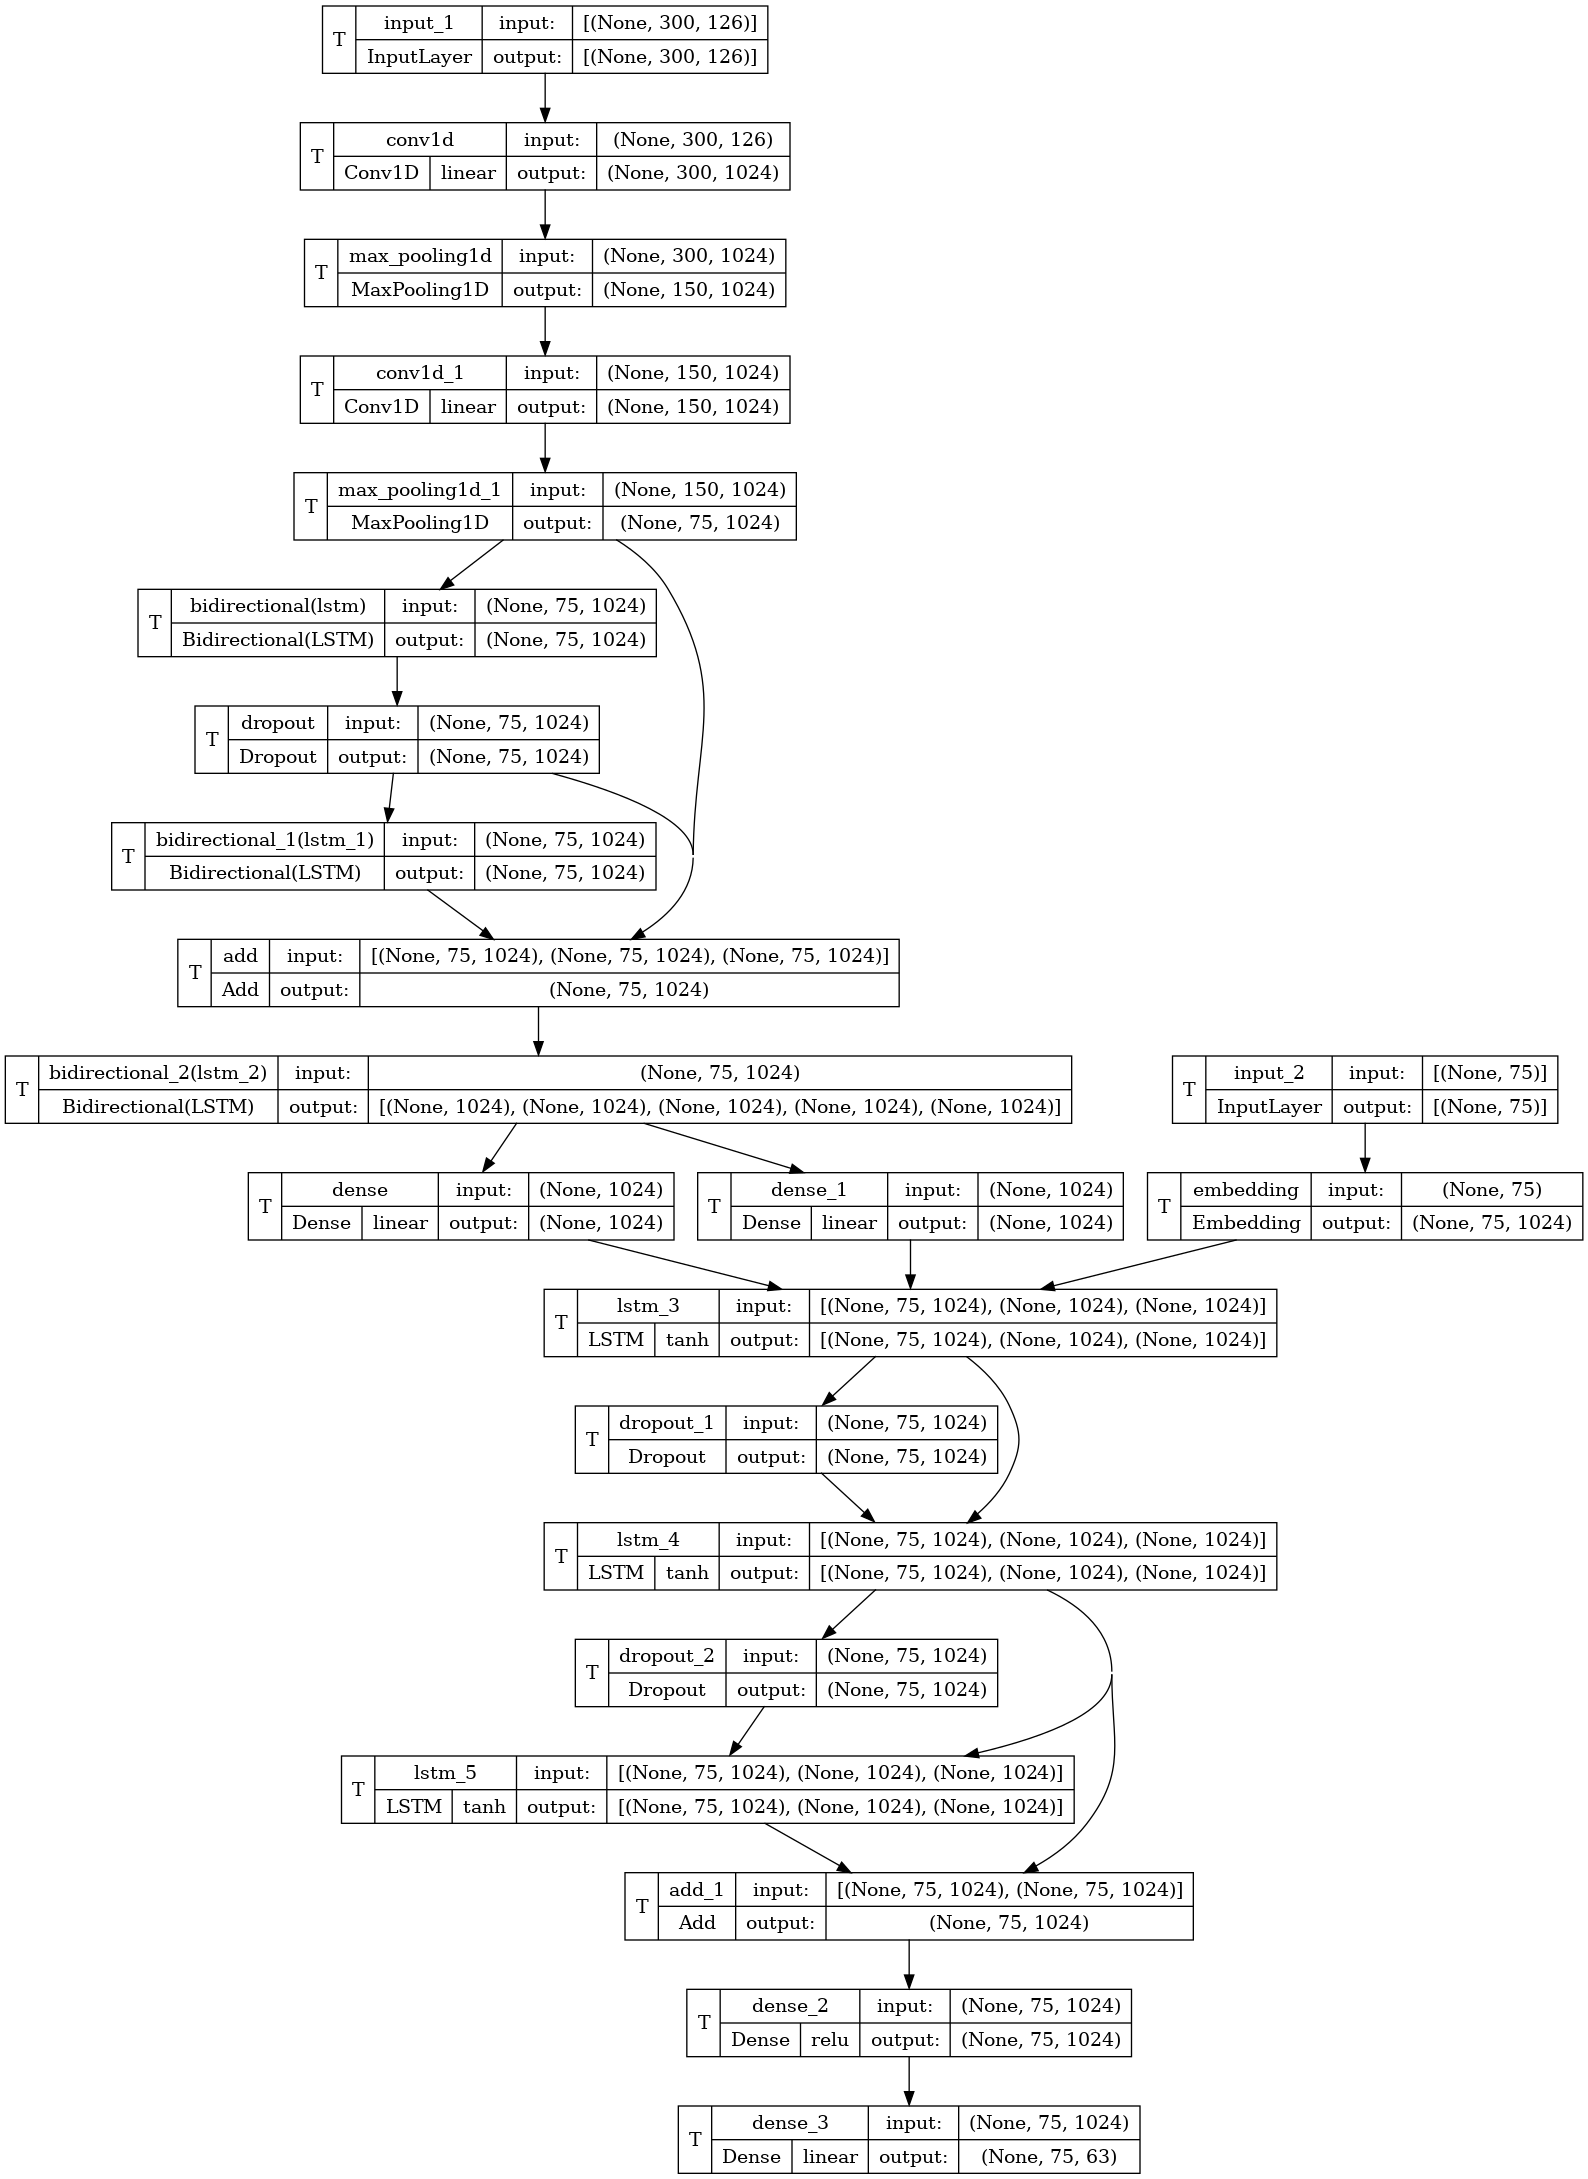

In [27]:
tf.keras.utils.plot_model(m, show_shapes=True, show_layer_activations=True, show_trainable=True)

## Define Loss Function, Optimizer, Perfomance Metric

In [28]:
def masked_accuracy(y_true, y_pred):
    """
    Calculate accuracy while masking out padded tokens in zero-padded sequences using TensorFlow.

    Parameters:
    - y_true: True labels, a 2D tensor of shape (batch_size, sequence_length) where padding is represented as 0.
    - y_pred: Predicted labels, a 2D tensor of the same shape as y_true.

    Returns:
    - accuracy: A scalar tensor representing the accuracy.
    """

    # Create a mask for non-padded tokens by checking where y_true is not equal to 0.
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=tf.float32)

    # Calculate the number of correctly classified non-padded tokens.
    correct_tokens = tf.reduce_sum(tf.cast(tf.math.equal(y_true, y_pred), dtype=tf.float32) * mask)

    # Calculate the total number of non-padded tokens in the batch.
    total_tokens = tf.reduce_sum(mask)

    # Calculate the accuracy by dividing the correct non-padded tokens by the total non-padded tokens.
    accuracy = correct_tokens / total_tokens

    return accuracy

In [29]:
optmizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
lossfn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# metrics = tf.keras.metrics.Accuracy()
metrics = masked_accuracy

In [30]:
# m.compile(optimizer=optmizer, loss=lossfn, metrics=[metrics])

## Train On Data

In [31]:
epochs = 20
train_step_per_epoch = train_df.shape[0]//batch_size
validation_step_per_epoch = test_df.shape[0]//batch_size

In [32]:
# ! pip install ipywidgets

In [33]:
tr_it = train_dataset.as_numpy_iterator()
ts_it = test_dataset.as_numpy_iterator()

for epoch in range(epochs):
    print(f"Training for Epoch: {epoch+1}/{epochs}")
    cum_loss = 0
    cum_acc = 0
    for i in (pbar:=tqdm(range(train_step_per_epoch))):
        x_batch, y_batch = tr_it.next()
        with tf.GradientTape() as tape:
            logits = m(x_batch, training=True)
            loss_value = lossfn(y_batch, logits)
        grads = tape.gradient(loss_value, m.trainable_weights)
        optmizer.apply_gradients(zip(grads, m.trainable_weights))
        acc = metrics(y_batch, tf.argmax(logits, axis=-1))

        cum_loss += loss_value.numpy()
        cum_acc += acc.numpy()
        
        lossstr = str(np.round(cum_loss/(i+1), 4))
        accstr = str(np.round(cum_acc/(i+1)*100,3))+"%"
        pbar.set_description(f"Loss: {lossstr}, Accuracy: {accstr}")
    print(f"Avg. Loss{cum_loss/train_step_per_epoch}, Avg. Accuracy {cum_acc*100/train_step_per_epoch}%")
    print(f"Validating...")
    cum_loss = 0
    cum_acc = 0
    for i in (pbar:=tqdm(range(validation_step_per_epoch))):
        x_batch, y_batch = ts_it.next()
        logits = m(x_batch, training=False)        
        loss_value = lossfn(y_batch, logits)
        acc = metrics(y_batch, tf.argmax(logits, axis=-1))

        cum_loss += loss_value.numpy()
        cum_acc += acc.numpy()
        
        lossstr = str(np.round(cum_loss/(i+1), 4))
        accstr = str(np.round(cum_acc/(i+1)*100,3))+"%"
        pbar.set_description(f"Loss: {lossstr}, Accuracy: {accstr}")
    print(f"Avg. Loss{cum_loss/validation_step_per_epoch}, Avg. Accuracy {cum_acc*100/validation_step_per_epoch}%")
    print("=="*70)

Training for Epoch: 1/20


  0%|          | 0/1680 [00:00<?, ?it/s]

Avg. Loss0.6097698290610597, Avg. Accuracy 30.04055632202099%
Validating...


  0%|          | 0/420 [00:00<?, ?it/s]

Avg. Loss0.45731328974167507, Avg. Accuracy 44.84648474625179%
Training for Epoch: 2/20


  0%|          | 0/1680 [00:00<?, ?it/s]

Avg. Loss0.3733999190142467, Avg. Accuracy 53.81625365998064%
Validating...


  0%|          | 0/420 [00:00<?, ?it/s]

Avg. Loss0.31308290915829795, Avg. Accuracy 61.19047455844425%
Training for Epoch: 3/20


  0%|          | 0/1680 [00:00<?, ?it/s]

Avg. Loss0.23699945694811286, Avg. Accuracy 69.33746501803398%
Validating...


  0%|          | 0/420 [00:00<?, ?it/s]

Avg. Loss0.2562578148785092, Avg. Accuracy 69.36919196730568%
Training for Epoch: 4/20


  0%|          | 0/1680 [00:00<?, ?it/s]

Avg. Loss0.14927158601848142, Avg. Accuracy 79.84380377190453%
Validating...


  0%|          | 0/420 [00:00<?, ?it/s]

Avg. Loss0.24703908984859785, Avg. Accuracy 73.44949635721389%
Training for Epoch: 5/20


  0%|          | 0/1680 [00:00<?, ?it/s]

Avg. Loss0.09451196543162778, Avg. Accuracy 86.62473737483933%
Validating...


  0%|          | 0/420 [00:00<?, ?it/s]

Avg. Loss0.24799827473858993, Avg. Accuracy 76.9499355270749%
Training for Epoch: 6/20


  0%|          | 0/1680 [00:00<?, ?it/s]

Avg. Loss0.06506024748973903, Avg. Accuracy 90.74008623404163%
Validating...


  0%|          | 0/420 [00:00<?, ?it/s]

Avg. Loss0.25007661199640663, Avg. Accuracy 79.53133540494102%
Training for Epoch: 7/20


  0%|          | 0/1680 [00:00<?, ?it/s]

Avg. Loss0.04310326712937759, Avg. Accuracy 94.13553743490151%
Validating...


  0%|          | 0/420 [00:00<?, ?it/s]

Avg. Loss0.24625334434566043, Avg. Accuracy 81.8264351714225%
Training for Epoch: 8/20


  0%|          | 0/1680 [00:00<?, ?it/s]

Avg. Loss0.029886782678243306, Avg. Accuracy 96.05768568459011%
Validating...


  0%|          | 0/420 [00:00<?, ?it/s]

Avg. Loss0.25164442683259647, Avg. Accuracy 82.81175481421607%
Training for Epoch: 9/20


  0%|          | 0/1680 [00:00<?, ?it/s]

Avg. Loss0.023553493708771255, Avg. Accuracy 96.93755812588192%
Validating...


  0%|          | 0/420 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Avg. Loss0.01961435367480763, Avg. Accuracy 97.45665604869525%
Validating...


  0%|          | 0/420 [00:00<?, ?it/s]

Avg. Loss0.2705106899497055, Avg. Accuracy 83.18878420761654%
Training for Epoch: 11/20


  0%|          | 0/1680 [00:00<?, ?it/s]

Avg. Loss0.01744058776946206, Avg. Accuracy 97.75365785473869%
Validating...


  0%|          | 0/420 [00:00<?, ?it/s]

Avg. Loss0.27710209598853475, Avg. Accuracy 83.51264861367997%
Training for Epoch: 12/20


  0%|          | 0/1680 [00:00<?, ?it/s]

Avg. Loss0.01517295024158167, Avg. Accuracy 98.05094486191159%
Validating...


  0%|          | 0/420 [00:00<?, ?it/s]

Avg. Loss0.2849040111260755, Avg. Accuracy 83.35118381750016%
Training for Epoch: 13/20


  0%|          | 0/1680 [00:00<?, ?it/s]

Avg. Loss0.013593341484166948, Avg. Accuracy 98.26966595082055%
Validating...


  0%|          | 0/420 [00:00<?, ?it/s]

Avg. Loss0.2830900337901853, Avg. Accuracy 83.68112311476753%
Training for Epoch: 14/20


  0%|          | 0/1680 [00:00<?, ?it/s]

Avg. Loss0.012529324940294915, Avg. Accuracy 98.39305322794687%
Validating...


  0%|          | 0/420 [00:00<?, ?it/s]

Avg. Loss0.2862746730269421, Avg. Accuracy 83.5973934900193%
Training for Epoch: 15/20


  0%|          | 0/1680 [00:00<?, ?it/s]

Avg. Loss0.012951544476423545, Avg. Accuracy 98.34910506293888%
Validating...


  0%|          | 0/420 [00:00<?, ?it/s]

Avg. Loss0.2908845987880514, Avg. Accuracy 84.08058836346581%
Training for Epoch: 16/20


  0%|          | 0/1680 [00:00<?, ?it/s]

Avg. Loss0.010504394401089355, Avg. Accuracy 98.67739979355107%
Validating...


  0%|          | 0/420 [00:00<?, ?it/s]

Avg. Loss0.3028251396758216, Avg. Accuracy 83.88365798053287%
Training for Epoch: 17/20


  0%|          | 0/1680 [00:00<?, ?it/s]

Avg. Loss0.010340314689286364, Avg. Accuracy 98.70434275340466%
Validating...


  0%|          | 0/420 [00:00<?, ?it/s]

Avg. Loss0.30441758735548885, Avg. Accuracy 84.07618254423141%
Training for Epoch: 18/20


  0%|          | 0/1680 [00:00<?, ?it/s]

Avg. Loss0.009737176556414592, Avg. Accuracy 98.74930476858502%
Validating...


  0%|          | 0/420 [00:00<?, ?it/s]

Avg. Loss0.31022530567078366, Avg. Accuracy 83.99953352553504%
Training for Epoch: 19/20


  0%|          | 0/1680 [00:00<?, ?it/s]

Avg. Loss0.009723857105529445, Avg. Accuracy 98.77194299939133%
Validating...


  0%|          | 0/420 [00:00<?, ?it/s]

Avg. Loss0.31224888376891613, Avg. Accuracy 84.01405605531875%
Training for Epoch: 20/20


  0%|          | 0/1680 [00:00<?, ?it/s]

Avg. Loss0.008993509986820365, Avg. Accuracy 98.85648477290358%
Validating...


  0%|          | 0/420 [00:00<?, ?it/s]

Avg. Loss0.3230972905953725, Avg. Accuracy 83.77350829896473%


In [83]:
m.save("Full Model.h5")

In [34]:
file_manager.keys()

dict_keys([5414471, 105143404, 128822441, 149822653, 152029243, 169560558, 175396851, 234418913, 296317215, 349393104, 388576474, 425182931, 433948159, 450474571, 474255203, 495378749, 522550314, 527708222, 532011803, 546816846, 566963657, 568753759, 614661748, 638508439, 649779897, 654436541, 683666742, 871280215, 882979387, 933868835, 939623093, 1019715464, 1021040628, 1098899348, 1099408314, 1133664520, 1134756332, 1255240050, 1320204318, 1341528257, 1358493307, 1365275733, 1365772051, 1405046009, 1448136004, 1497621680, 1552432300, 1557244878, 1562234637, 1643479812, 1647220008, 1662742697, 1664666588, 1726141437, 1785039512, 1865557033, 1880177496, 1905462118, 1906357076, 1920330615, 1967755728, 1969985709, 1997878546, 2026717426, 2036580525, 2072296290, 2072876091, 2118949241])

In [35]:
inverse_charmap = {v:k for k,v in charmap.items()}

In [36]:
texts = ["".join([inverse_charmap.get(i,"['UNK']") for i in seq if i not in [2,0]]) for seq in y_batch]
texts

['6738 conley branch[END]',
 '52741 birch o.1 street[END]',
 'geoffrey johnston[END]',
 'diane owen[END]',
 'girk-12606mhematogenesis[END]',
 '57636/2022-03-17.html[END]',
 'randi cummings[END]',
 '2340 twp 5223[END]',
 'leticia burns[END]',
 'melisa perez[END]',
 '420337 helens view[END]',
 '8566 buckwood[END]',
 '7388 trail street northwest[END]',
 'kak-ochistit-vannu[END]',
 '8819 nfd 6010 road[END]',
 'eli kaur[END]',
 'support.2k.com/usemistas[END]',
 '302 co 207[END]',
 'julianna juarez[END]',
 '2246 beatriz[END]',
 '4071 lower hardor way[END]',
 '4834 quanset[END]',
 '89068/repair-request-form[END]',
 '/smut/camila-neubarth[END]',
 'gagan-vihar[END]',
 'tiffanie oliver[END]',
 '5417 silurian lake[END]',
 '3692 hst west 12th street[END]',
 '1642 train band[END]',
 'cu.near-place.com/pngac/44075/[END]',
 '3756 sunnyfield avenue[END]',
 'high-metabolism/twinflamestar[END]']

In [37]:
logits = m.predict(x_batch)
texts_pred = ["".join([inverse_charmap.get(i,"['UNK']") for i in seq if i not in [2,0]]) for seq in tf.argmax(logits, axis=-1).numpy()]

1/1 [==============================] - 3s 3s/step


In [38]:
texts_pred

['6738 conbey branch[END]',
 '5274  birch sff 8treet[END]',
 'geoffrey johnston[END]',
 'diane owen[END]',
 'giyke120040/emanorunouur[END]',
 '07733/e001/17-13.html[END]',
 'randi cumiings[END]',
 '2340 twp 2224[END]',
 'leticia burna[END]',
 'melisa perez[END]',
 '420337 helens view[END]',
 '8566 buckwood[END]',
 '7387 trail street northwest[END]',
 'kaz-svtiparcamanaa[END]',
 '8819 nfd 6010 road[END]',
 'eli kaur[END]',
 'support.2k.com/usemistas[END]',
 '302 co 207[END]',
 'julianna juarez[END]',
 '2246 beatriz[END]',
 '4071 lower harrow way[END]',
 '4834 quanset[END]',
 '89068/dezarr/cosuest-2oru[END]',
 '/smur-aarinn-newrlkeh[END]',
 'gaban-mibec[END]',
 'tiffanie obivor[END]',
 '5417 silonaan lake[END]',
 '3692 hst west 12th street[END]',
 '1643 trail bank[END]',
 'c--sawrmglace.com//ragntc5335/[END]',
 '3756 sunnyfield avenue[END]',
 'high-cesalire-hhhhenhaeshnter[END]']

In [40]:
for a,p in zip(texts, texts_pred):
    print(f"Actual: {a} ===> Predicted: {p}")

Actual: 6738 conley branch[END] ===> Predicted: 6738 conbey branch[END]
Actual: 52741 birch o.1 street[END] ===> Predicted: 5274  birch sff 8treet[END]
Actual: geoffrey johnston[END] ===> Predicted: geoffrey johnston[END]
Actual: diane owen[END] ===> Predicted: diane owen[END]
Actual: girk-12606mhematogenesis[END] ===> Predicted: giyke120040/emanorunouur[END]
Actual: 57636/2022-03-17.html[END] ===> Predicted: 07733/e001/17-13.html[END]
Actual: randi cummings[END] ===> Predicted: randi cumiings[END]
Actual: 2340 twp 5223[END] ===> Predicted: 2340 twp 2224[END]
Actual: leticia burns[END] ===> Predicted: leticia burna[END]
Actual: melisa perez[END] ===> Predicted: melisa perez[END]
Actual: 420337 helens view[END] ===> Predicted: 420337 helens view[END]
Actual: 8566 buckwood[END] ===> Predicted: 8566 buckwood[END]
Actual: 7388 trail street northwest[END] ===> Predicted: 7387 trail street northwest[END]
Actual: kak-ochistit-vannu[END] ===> Predicted: kaz-svtiparcamanaa[END]
Actual: 8819 nfd

# Develop Final Encoder-Decoder Separator Model

One dense layer is lost as same variable is used. Now we have to filter it by name

In [49]:
for layer in m.layers:
    if layer.name=='dense_1':
        break

In [51]:
layer.name

'dense_1'

In [52]:
# Encoder
enc_inp_model = Input(shape=(None, len(handcolumns)))

conv1out_model = conv1d(enc_inp_model)
poolout_model = maxpool1d(conv1out_model)

conv1out2_model = conv1d2(poolout_model)
poolout2_model = maxpool1d2(conv1out2_model)

bilstm_out_model = bilstm(poolout2_model)
dropout_enc_model = Dropout(0.3)(bilstm_out_model)
bilstm2_out_model = bilstm2(bilstm_out_model)

added_model = skip_layer([poolout2_model,bilstm2_out_model, dropout_enc_model])

enc_x_model, f_h_model, f_c_model, b_h_model, b_c_model = bilstm3(added_model)

# Transform States
b_hT_model = dense1(b_h_model)
b_cT_model = layer(b_c_model)

encoder_model = Model(enc_inp_model, outputs=[b_hT_model, b_cT_model])

In [53]:
encoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, 126)]  0           []                               
                                                                                                  
 conv1d (Conv1D)                multiple             1033216     ['input_4[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   multiple             0           ['conv1d[2][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              multiple             5243904     ['max_pooling1d[2][0]']          
                                                                                            

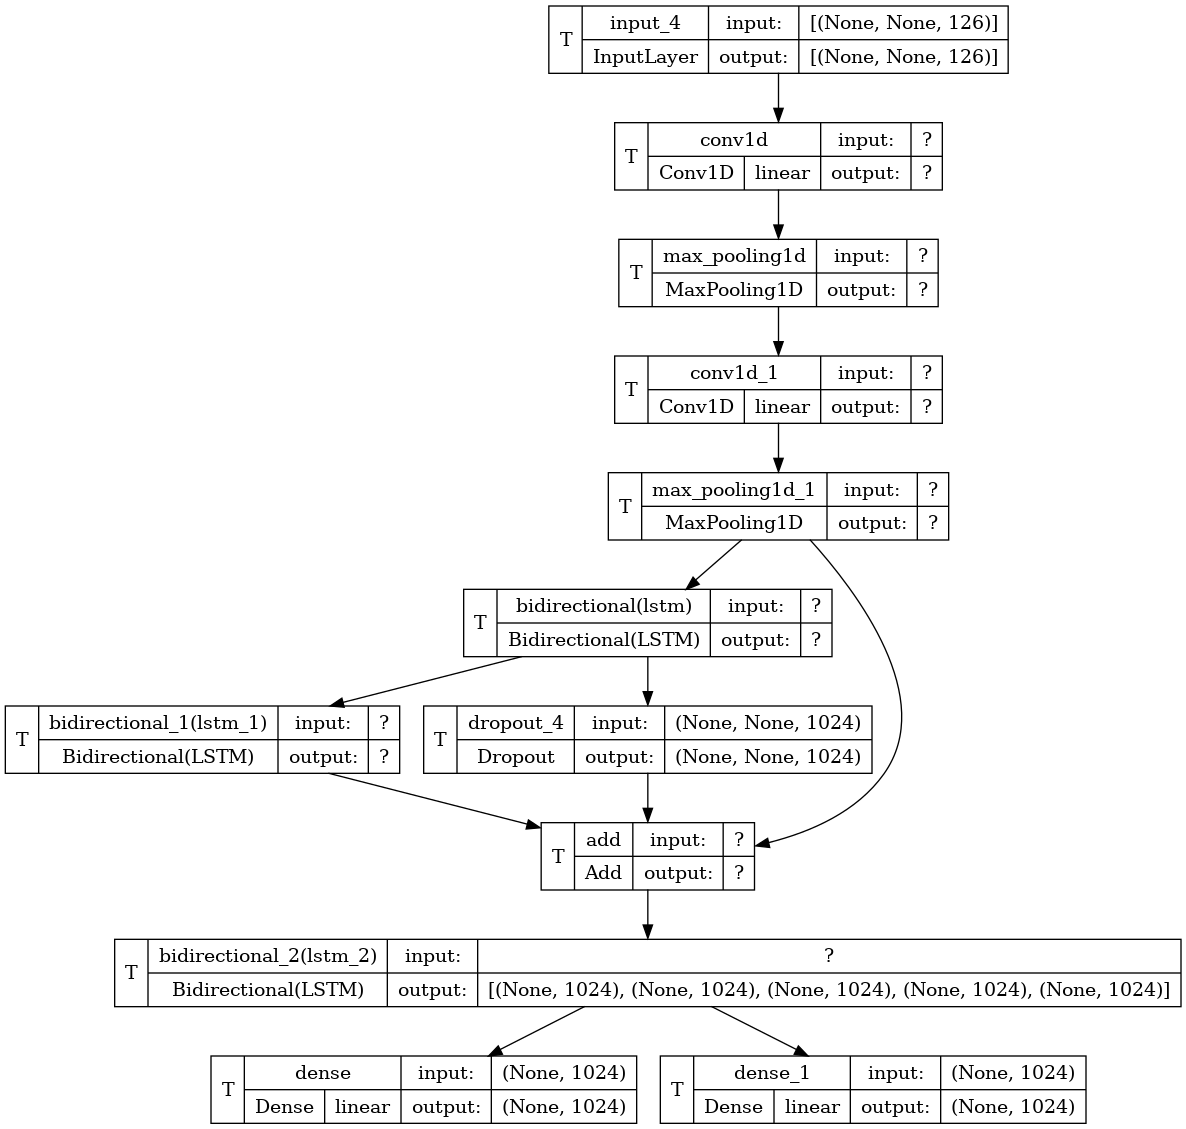

In [54]:
tf.keras.utils.plot_model(encoder_model, show_shapes=True, show_layer_activations=True, show_trainable=True)

In [55]:
oh,oc = encoder_model.predict(x_batch[0])

1/1 [==============================] - 2s 2s/step


In [56]:
oh.shape, oc.shape

((32, 1024), (32, 1024))

In [84]:
encoder_model.save("encoder.h5")

In [63]:
# Decoder
dec_inp_model = Input(shape=(1,))
b_hT_inp = Input(shape=(1024,))
b_cT_inp = Input(shape=(1024,))
embeddings_model = emb_layer(dec_inp_model)
dec_lstm_before_out_model, f_h1_model, f_c1_model = lstm_before(embeddings_model,initial_state=[b_hT_inp, b_cT_inp])
dropout_dec1_model = Dropout(0.5)(dec_lstm_before_out_model)
dec_lstm_out1_model, f_h2_model, f_c2_model = lstm_dec(dropout_dec1_model, initial_state=[f_h1_model, f_c1_model])
dropout_dec_model = Dropout(0.5)(dec_lstm_out1_model)
dec_lstm_out2_model, dec_f_h_model, dec_f_c_model = lstm_dec2(dropout_dec_model, initial_state=[f_h2_model, f_c2_model])


dec_added_model = dec_skip_layer([dec_lstm_out1_model, dec_lstm_out2_model])

dense_out_model = dense(dec_added_model)
# dense2 = Dense(len(charmap), activation='linear')
dense_out2_model = dense2(dense_out_model)
decoder_model = Model(inputs=[dec_inp_model, b_hT_inp, b_cT_inp], outputs = [dense_out2_model, f_h1_model, f_c1_model])

In [64]:
decoder_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          multiple             64512       ['input_11[0][0]']               
                                                                                                  
 input_12 (InputLayer)          [(None, 1024)]       0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 1024)]       0           []                               
                                                                                            

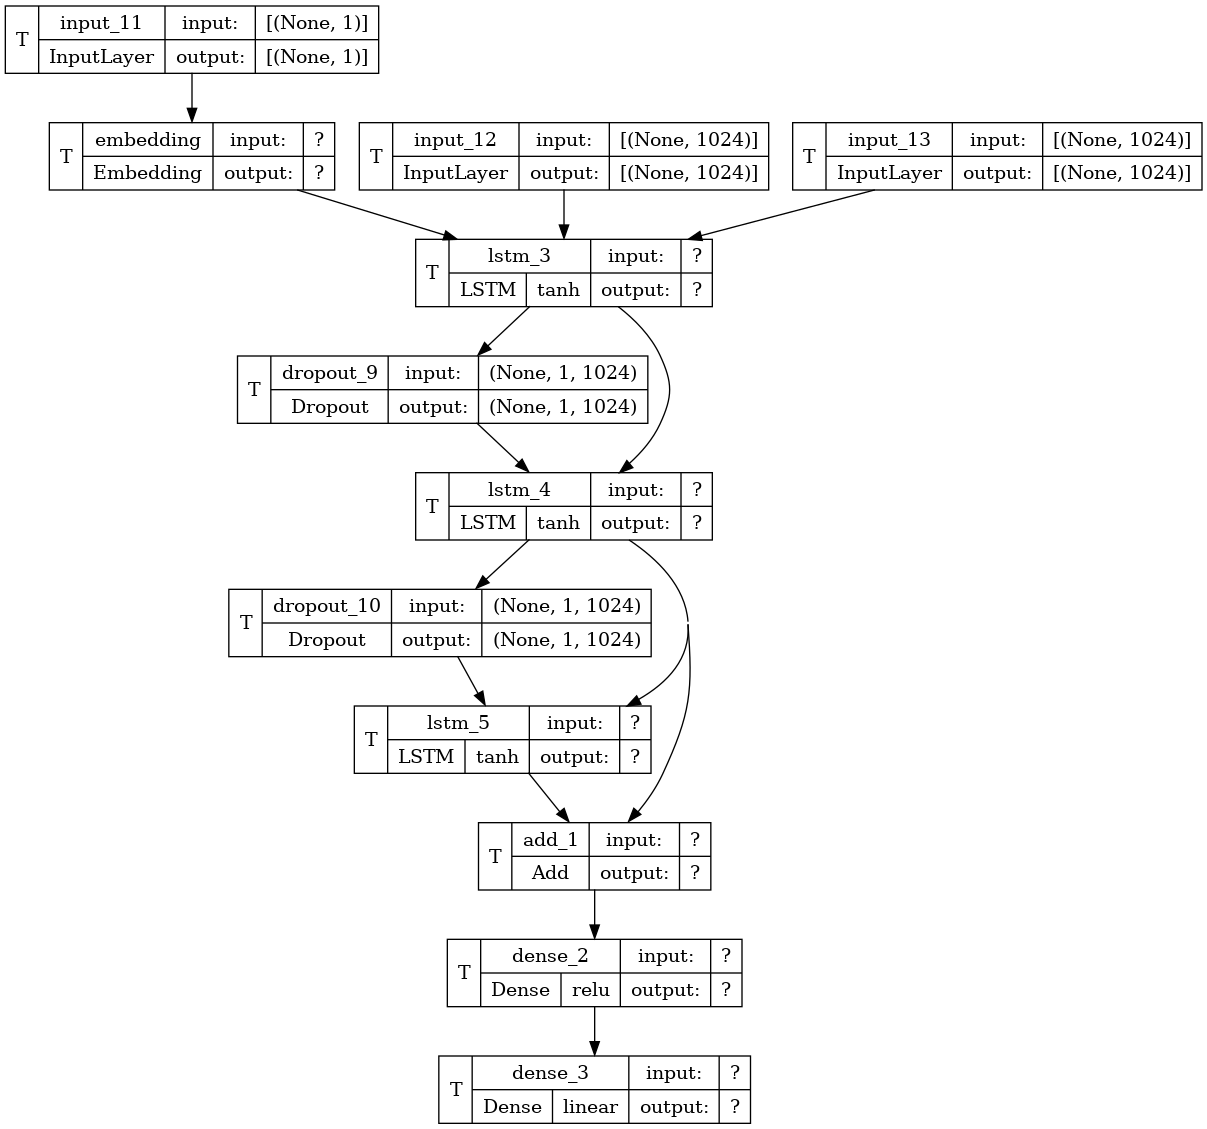

In [65]:
tf.keras.utils.plot_model(decoder_model, show_shapes=True, show_layer_activations=True, show_trainable=True)

In [85]:
decoder_model.save("decoder.h5")